In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.2 MB/s  0:00:02eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 4.7 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.7 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [2]:
"""基于风格/预算/房型从 model_infos_with_price.json 选出家具清单
使用方法示例：
- 设置参数后运行整段代码
"""

from __future__ import annotations
import json
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd

# ----------------------- 用户输入区域 -----------------------
room_image_path: str = str(Path("/Users/apple/Desktop/VirtualFurnishing/data/empty_room.jpg"))
budget_cny: float = 7000.0
style: str = "modern"  # 不区分大小写
room_type: str = "living room"  # 目前支持：living room

# 选填：房间长宽 (米)。若为 None，则使用保守阈值限制单件尺寸
room_size_m: Tuple[float, float] | None = None  # 例如 (4.0, 3.2)

# ----------------------- 参数与常量 -----------------------
DATA_JSON = Path("../data/model_infos_with_price.json")

# 客厅优先品类（category 或 super-category，区分大小写按数据为准）
LIVING_ROOM_CATEGORY_WHITELIST = {
    # super-category
    "Sofa", "Lighting", "Cabinet/Shelf/Desk",
    # category 细分
    "armchair", "Loveseat Sofa", "L-shaped Sofa", "Sofa",
    "Coffee Table", "TV Stand", "Bookcase / jewelry Armoire",
    "Pendant Lamp", "Floor Lamp",
}

# 当未提供房间长宽时，对单件设置的保守尺寸上限（米）
FALLBACK_MAX_LEN = 2.6  # xLen 最大长度（常见三人沙发约 2.0~2.6）
FALLBACK_MAX_DEPTH = 1.2  # zLen 最大深度

# 想要的基础搭配（每类挑 0~1 件，尽量满足）
CORE_SET_BY_ROOM = {
    "living room": [
        ("Sofa", {"Sofa", "armchair", "Loveseat Sofa", "L-shaped Sofa"}),
        ("Coffee Table", {"Coffee Table"}),
        ("TV Stand", {"TV Stand"}),
        ("Lighting", {"Pendant Lamp", "Floor Lamp"}),
    ]
}

# ----------------------- 数据加载与规范化 -----------------------
with DATA_JSON.open("r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.json_normalize(data)

# 统一大小写便于筛选
if "style" in df.columns:
    df["style_norm"] = df["style"].astype(str).str.strip().str.lower()
else:
    df["style_norm"] = ""

df["category_norm"] = df["category"].astype(str).str.strip()
df["super_norm"] = df["super-category"].astype(str).str.strip()

# 面积与尺寸
df["xLen"] = df["size.xLen"].astype(float)
df["zLen"] = df["size.zLen"].astype(float)

df["footprint_m2"] = df["xLen"] * df["zLen"]

# ----------------------- 筛选：房型&风格&尺寸 -----------------------
# 房型：仅保留客厅常见品类
df_lr = df[(df["category_norm"].isin(LIVING_ROOM_CATEGORY_WHITELIST)) | (df["super_norm"].isin(LIVING_ROOM_CATEGORY_WHITELIST))].copy()

# 风格（不区分大小写）
style_norm = style.strip().lower()
if style_norm:
    df_lr = df_lr[df_lr["style_norm"] == style_norm]

# 尺寸限制：若提供房间长宽，则单件不得超过房间长/宽；否则使用保守阈值
if room_size_m is not None:
    room_len, room_depth = room_size_m
    df_lr = df_lr[(df_lr["xLen"] <= room_len) & (df_lr["zLen"] <= room_depth)]
else:
    df_lr = df_lr[(df_lr["xLen"] <= FALLBACK_MAX_LEN) & (df_lr["zLen"] <= FALLBACK_MAX_DEPTH)]

# ----------------------- 规则约束组合：严格遵守家具间关系与通行间距 -----------------------
selected: List[Dict] = []
remaining_budget = float(budget_cny)

# 通用集合（根据需求：只要 L-shaped Sofa，不要 armchair）
SOFA_CATS = {"L-shaped Sofa"}
COFFEE_CATS = {"Coffee Table"}
TVSTAND_CATS = {"TV Stand"}
ARMCHAIR_CATS = set()
LIGHTING_CATS = {"Pendant Lamp", "Floor Lamp"}
BOOKCASE_CATS = {"Bookcase / jewelry Armoire"}

# 规则参数（米）
CLEAR_SOFA_TABLE = 0.5   # 沙发-茶几通行距离
CLEAR_TABLE_TV = 0.5     # 茶几-电视柜通行距离
TABLE_WIDTH_RATIO = (0.4, 0.7)  # 茶几宽度占沙发宽度比例
TV_TO_SOFA_RATIO = (0.6, 1.5)   # 电视柜宽度相对沙发
MAX_TABLE_DEPTH = 1.0

# 辅助函数

def pick_first_affordable(subset: pd.DataFrame, budget: float) -> Dict | None:
    subset = subset[subset["price_cny"].notna()].sort_values("price_cny")
    for _, row in subset.iterrows():
        if float(row["price_cny"]) <= budget:
            return row.to_dict()
    return None

# 候选集
cand_sofa = df_lr[df_lr["category_norm"].isin(SOFA_CATS)].copy()
cand_table = df_lr[df_lr["category_norm"].isin(COFFEE_CATS)].copy()
cand_tv = df_lr[df_lr["category_norm"].isin(TVSTAND_CATS)].copy()
cand_arm = df_lr[df_lr["category_norm"].isin(ARMCHAIR_CATS)].copy()
cand_light = df_lr[df_lr["category_norm"].isin(LIGHTING_CATS)].copy()
cand_book = df_lr[df_lr["category_norm"].isin(BOOKCASE_CATS)].copy()

# 1) 选沙发（先保证预算与尺寸）
sofa = pick_first_affordable(cand_sofa, remaining_budget)
if sofa is not None:
    selected.append(sofa)
    remaining_budget -= float(sofa["price_cny"])  # type: ignore

# 2) 选茶几（满足比例与通行距离）
coffee = None
if sofa is not None:
    sofa_w = float(sofa["xLen"])  # type: ignore
    sofa_d = float(sofa["zLen"])  # type: ignore
    min_w = TABLE_WIDTH_RATIO[0] * sofa_w
    max_w = TABLE_WIDTH_RATIO[1] * sofa_w
    subset = cand_table[(cand_table["xLen"] >= min_w) & (cand_table["xLen"] <= max_w) & (cand_table["zLen"] <= MAX_TABLE_DEPTH)]
    # 房间深度约束
    if room_size_m is not None:
        room_len, room_depth = room_size_m
        subset = subset[(sofa_d + CLEAR_SOFA_TABLE + subset["zLen"] + CLEAR_TABLE_TV) <= room_depth]
        subset = subset[(subset["xLen"] <= room_len) & (sofa_w <= room_len)]
    coffee = pick_first_affordable(subset, remaining_budget)
    if coffee is not None:
        selected.append(coffee)
        remaining_budget -= float(coffee["price_cny"])  # type: ignore

# 3) 选电视柜（与沙发宽度匹配，并受房间长宽约束）
tv = None
if sofa is not None:
    sofa_w = float(sofa["xLen"])  # type: ignore
    subset = cand_tv[(cand_tv["xLen"] >= TV_TO_SOFA_RATIO[0] * sofa_w) & (cand_tv["xLen"] <= TV_TO_SOFA_RATIO[1] * sofa_w)]
    if room_size_m is not None:
        room_len, room_depth = room_size_m
        subset = subset[(subset["xLen"] <= room_len) & (sofa_w <= room_len)]
        # 深度链：若有茶几，则校验纵深；没有茶几按最小通道估算
        sofa_d = float(sofa["zLen"])  # type: ignore
        est_table_d = float(coffee["zLen"]) if coffee is not None else 0.6
        subset = subset[(sofa_d + CLEAR_SOFA_TABLE + est_table_d + CLEAR_TABLE_TV) <= room_depth]
    tv = pick_first_affordable(subset, remaining_budget)
    if tv is not None:
        selected.append(tv)
        remaining_budget -= float(tv["price_cny"])  # type: ignore

# 4) 跳过单椅：按需求不选择 armchair
arm = None

# 5) 选照明/书柜等（不破坏房间长宽约束的前提下尽量花完预算）
extras_pool = pd.concat([cand_light, cand_book], ignore_index=True)
extras_pool = extras_pool[extras_pool["price_cny"].notna()].sort_values("price_cny", ascending=False)

selected_ids = {it.get("model_id") for it in selected}

def fits_room_width(row: pd.Series) -> bool:
    if room_size_m is None:
        return True
    room_len, _ = room_size_m
    return float(row["xLen"]) <= room_len

for _, row in extras_pool.iterrows():
    price = float(row["price_cny"])  # type: ignore
    if price > remaining_budget:
        continue
    if row["model_id"] in selected_ids:
        continue
    if not fits_room_width(row):
        continue
    selected.append(row.to_dict())
    selected_ids.add(row["model_id"])  # type: ignore
    remaining_budget -= price
    if remaining_budget <= 0:
        break

# ----------------------- 预算填充：在不违反任何已选规则的前提下继续添加同风格低优先级品类 -----------------------
# 这里仅在预算允许且不触发房间长宽硬约束时追加更多灯或书柜
if remaining_budget > 0:
    for _, row in extras_pool.iterrows():
        price = float(row["price_cny"])  # type: ignore
        if row["model_id"] in selected_ids or price > remaining_budget:
            continue
        if not fits_room_width(row):
            continue
        selected.append(row.to_dict())
        selected_ids.add(row["model_id"])  # type: ignore
        remaining_budget -= price
        if remaining_budget <= 0:
            break

# ----------------------- 输出结果 -----------------------
result_columns = [
    "model_id", "super-category", "category", "style", "price_cny",
    "xLen", "zLen", "footprint_m2"
]

def render_brief(items: List[Dict]) -> pd.DataFrame:
    if not items:
        return pd.DataFrame(columns=result_columns)
    df_out = pd.DataFrame(items)
    for col in result_columns:
        if col not in df_out.columns:
            df_out[col] = None
    return df_out[result_columns].reset_index(drop=True)

selection_df = render_brief(selected)
print(f"房间图: {room_image_path}")
print(f"房型: {room_type} | 风格: {style} | 预算: ¥{budget_cny:.0f} | 余 ¥{remaining_budget:.0f}")

selection_df

房间图: /Users/apple/Desktop/VirtualFurnishing/data/empty_room.jpg
房型: living room | 风格: modern | 预算: ¥7000 | 余 ¥10


,model_id,super-category,category,style,price_cny,xLen,zLen,footprint_m2
0,b8b746a5-bf6e-4679-a702-e783140cc4d8,Sofa,L-shaped Sofa,Modern,4660,2.087,0.961,2.005607
1,06791438-cfa8-4e29-95cc-4ff8107e3456,Cabinet/Shelf/Desk,Coffee Table,Modern,200,1.080,0.174,0.187920
2,1a4af735-398a-483b-ad94-68baeb0517bd,Cabinet/Shelf/Desk,TV Stand,Modern,280,1.400,0.482,0.674800
3,c4b1e776-0cf2-4db0-b303-5ff29d0be5fa,Cabinet/Shelf/Desk,Bookcase / jewelry Armoire,Modern,1400,1.635,0.923,1.509105
4,6289a052-b4a7-417a-b687-b22fddc14663,Lighting,Pendant Lamp,Modern,450,1.576,1.032,1.626432


In [4]:
# 保存到 JSON 文件（UTF-8, records 格式）
from pathlib import Path as _P
_out_json = _P("/Users/apple/Desktop/VirtualFurnishing/furniture_select/selection.json")
_out_json.parent.mkdir(parents=True, exist_ok=True)
selection_df.to_json(_out_json, orient="records", force_ascii=False, indent=2)
print(f"已保存: {_out_json}")

已保存: /Users/apple/Desktop/VirtualFurnishing/furniture_select/selection.json


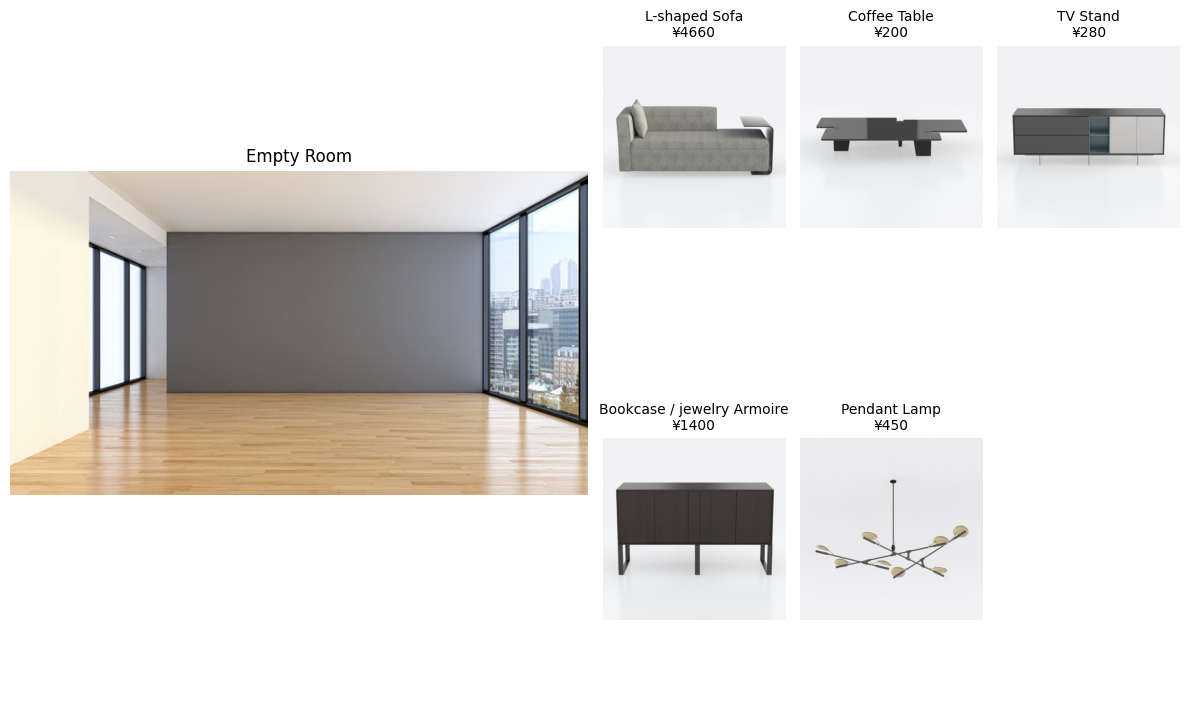

拼图已保存: /Users/apple/Desktop/VirtualFurnishing/outputs/selection_collage.png


In [5]:
# 将所选家具的图片拼接成一张画布
from pathlib import Path
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images_dir = Path("/Users/apple/Desktop/VirtualFurnishing/data/modern_images")
output_path = Path("/Users/apple/Desktop/VirtualFurnishing/outputs/selection_collage.png")
output_path.parent.mkdir(parents=True, exist_ok=True)

# 基于 selection_df 查找图片
model_rows = []
if 'selection_df' in globals():
    model_rows = selection_df.to_dict(orient='records')

exts = [".jpg", ".jpeg", ".png", ".webp"]

def find_image_path(model_id: str) -> Path | None:
    for ext in exts:
        p = images_dir / f"{model_id}{ext}"
        if p.exists():
            return p
    # 容错：尝试大小写不敏感和包含子目录的情况
    for p in images_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts and model_id.lower() in p.stem.lower():
            return p
    return None

image_items = []
# 先加入空房图（若存在）
try:
    from pathlib import Path as _P
    if 'room_image_path' in globals() and _P(room_image_path).exists():
        image_items.append((_P(room_image_path), "Empty Room"))
except Exception:
    pass

for row in model_rows:
    mid = str(row.get('model_id'))
    p = find_image_path(mid)
    if p is None:
        continue
    title = f"{row.get('category','')}\n¥{row.get('price_cny','')}"
    image_items.append((p, title))

if not image_items:
    print("未在 data/modern_images 找到任何匹配图片。")
else:
    # 判断是否包含空房图（第一张）
    has_room = len(image_items) > 0 and image_items[0][1] == "Empty Room"
    items_right = image_items[1:] if has_room else image_items

    # 右侧网格参数
    ncols_right = 3
    n_right = len(items_right)
    nrows_right = max(1, math.ceil(n_right / ncols_right))

    # 画布：两列，左侧占 1/2，右侧占 1/2
    fig = plt.figure(figsize=(12, 4 * nrows_right))
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(nrows_right, 2 * ncols_right, figure=fig)

    # 左侧：让其占据一半宽度与全部高度
    ax_left = fig.add_subplot(gs[:, :ncols_right])
    if has_room:
        img_left = mpimg.imread(str(image_items[0][0]))
        ax_left.imshow(img_left)
        ax_left.set_title("Empty Room", fontsize=12)
    ax_left.axis('off')

    # 右侧：nrows_right x ncols_right 网格
    idx = 0
    for r in range(nrows_right):
        for c in range(ncols_right):
            ax = fig.add_subplot(gs[r, ncols_right + c])
            if idx < n_right:
                path, title = items_right[idx]
                img = mpimg.imread(path)
                ax.imshow(img)
                ax.set_title(title, fontsize=10)
            ax.axis('off')
            idx += 1

    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.show()
    print(f"拼图已保存: {output_path}")


In [26]:
!pip -q install opencv-python rembg openai pillow